In [1]:
from vade.model import VADE
from vade.data import DATASETS
from torch.utils.data import DataLoader
from vade.device import DEVICE
from sklearn.cluster import KMeans
import torch
import numpy as np
from sklearn.metrics import (
    rand_score,
    silhouette_score,
    calinski_harabasz_score,
)
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset_name = "MNIST"

In [3]:
model = (
    VADE.load_from_checkpoint(
        "results/2025-01-05__21-43-55/MNIST/VADE/BasicTraining/lightning_logs/version_0/checkpoints/best_model-epoch=53-val_loss=134.5143-train_loss=133.6757.ckpt"
    )
    .to(DEVICE)
    .double()
)

In [4]:
dataset = DATASETS[dataset_name]["test"]
dataloader = DataLoader(dataset, 32)

### Prediction generation

In [5]:
predictions = []
latent_representations = []
true_labels = []
for X, y in dataloader:
    X = X.to(DEVICE)
    with torch.no_grad():
        predictions.append(model(X))
        latent_representations.append(model.encode(X))
    true_labels.append(y)
predictions = torch.concat(predictions).cpu().numpy()
latent_representations = torch.concat(latent_representations).cpu().numpy()
true_labels = torch.concat(true_labels).cpu().numpy()
n_clusters = np.unique(true_labels).shape[0]

### Clustering of latent space vs true classes

In [6]:
clustering = KMeans(n_clusters=n_clusters, random_state=123)
clusters = clustering.fit_predict(latent_representations)
print(f"{rand_score(true_labels, clusters)}")

0.9087386338633864


### Clustering metrics of latent space

In [7]:
print(f"{silhouette_score(latent_representations, clusters).item()=}")
print(f"{calinski_harabasz_score(latent_representations, clusters).item()=}")

silhouette_score(latent_representations, clusters).item()=0.15001870108329235
calinski_harabasz_score(latent_representations, clusters).item()=1042.3051804912632


### Clusters visualizations
* (with true labels as colors)

In [8]:
stratified_sample_X = []
stratified_sample_true_labels = []
for i in range(n_clusters):
    stratified_sample_X.append(latent_representations[true_labels == i][:100])
    stratified_sample_true_labels.append(true_labels[true_labels == i][:100])
stratified_sample_X = np.concat(stratified_sample_X)
stratified_sample_true_labels = np.concat(stratified_sample_true_labels)

In [9]:
reduced_data = TSNE(2).fit_transform(stratified_sample_X)

<Axes: >

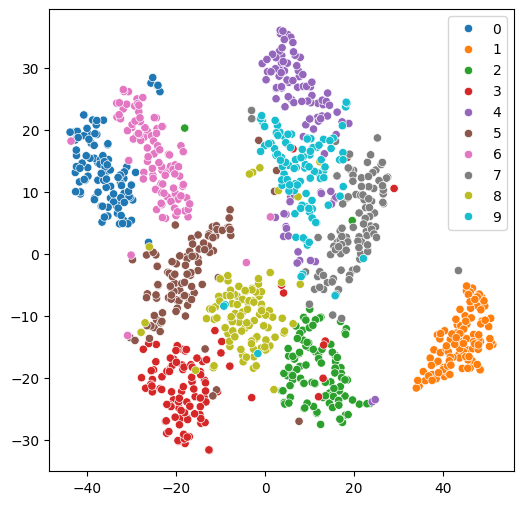

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    hue=stratified_sample_true_labels.tolist(),
    palette="tab10",
)

### Observation from each cluster 
* (for img visualize, for HAR calculate distance from points of this cluster, compare to distance from other cluster, compare to distances of real observations)

In [11]:
assert isinstance(model, VADE), "This result supports only VADE"

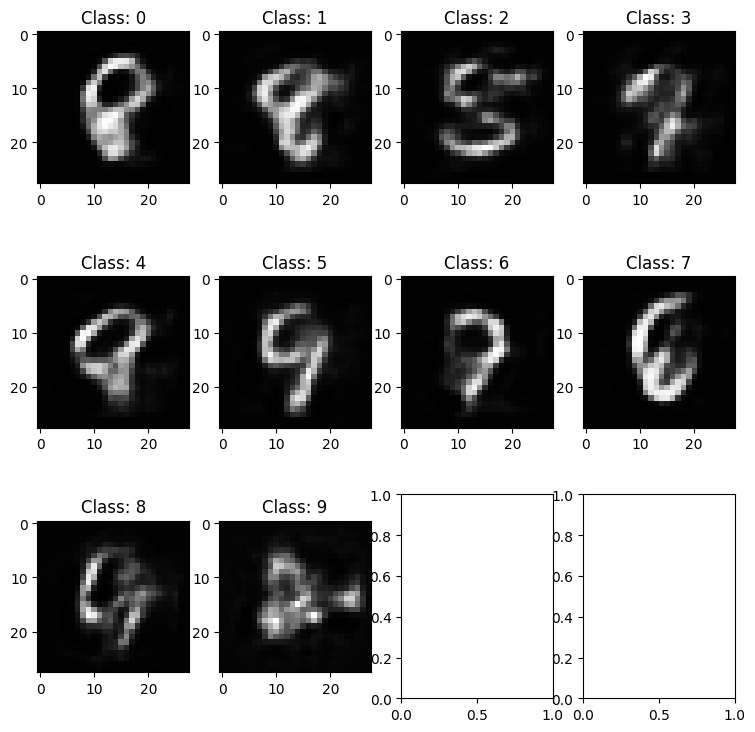

In [12]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(9, 9))
for class_ in range(10):
    r = torch.randn(size=(model.layers_sizes[-1],)).cuda()
    z = r * torch.exp(0.5 * model.logvar[class_]) + model.mu[class_]
    mu, logvar = model.mu_encoder(z), model.logvar_encoder(z)
    latent = model.reparametrize(mu, logvar)
    output = model.decode(latent)
    output_img = output.reshape(28, 28).cpu().detach().numpy()
    ax_to_plot = ax[class_ // 4][class_ % 4]
    ax_to_plot.imshow(output_img, cmap="gray")
    ax_to_plot.set_title(f"Class: {class_}")